In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

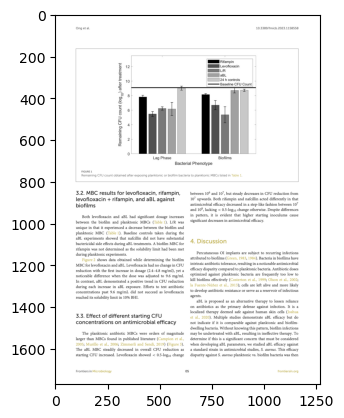

In [2]:
img_full = cv2.imread('./../../samples/imgPDF.png')
plt.imshow(img_full)

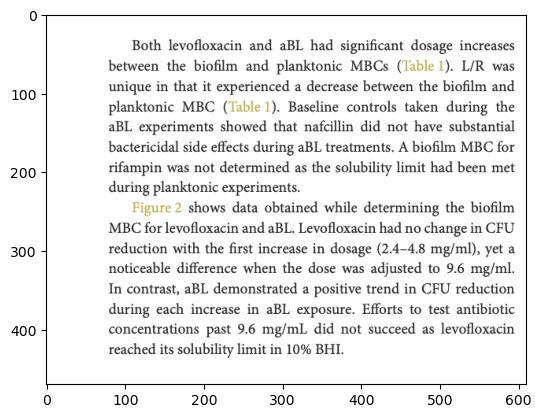

In [3]:
img = img_full[930:1400, 20:630]
plt.imshow(img)

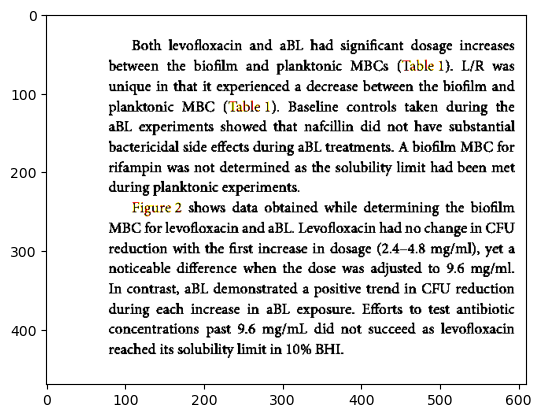

In [4]:
_,imgThresh1 = cv2.threshold(img,200,255,cv2.THRESH_BINARY)
plt.imshow(imgThresh1,cmap='gray')

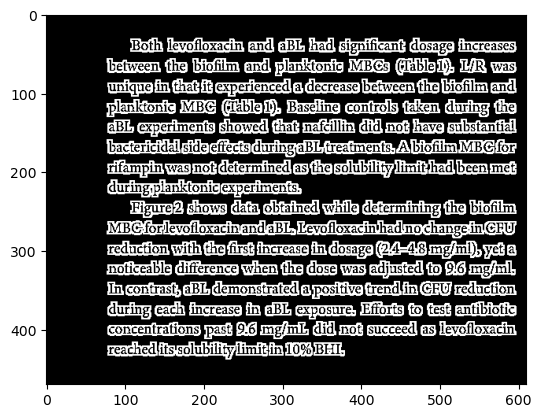

In [5]:
bs = 5
k = -0.2
maxval = 255
img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imgThresh2 = cv2.ximgproc.niBlackThreshold(img1,maxValue=maxval,
                                           type=cv2.THRESH_BINARY,blockSize=bs,k=k)
plt.imshow(imgThresh2,cmap='gray')

In [6]:
def preprocess(totalLabels,stats, centroids):
    #print(totalLabels,stats.shape,centroids.shape)
    columns = ['label_id', 'left','top','width','height','area','centroid_x','centroid_y']
    df = pd.DataFrame(columns=columns)
    df['label_id'] = [i for i in range(1,totalLabels+1)]
    df['left'] = stats[:,0]
    df['top'] = stats[:,1]
    df['width'] = stats[:,2]
    df['height'] = stats[:,3]
    df['area'] = stats[:,4]
    df['centroid_x'] = centroids[:,0]
    df['centroid_y'] = centroids[:,1]
    df['aspect_ratio'] = np.round(df['width']/df['height'],2)
    return df

In [7]:
def plot_components(df,comps=[]):
    output = img.copy() 
    for comp in comps:
        x, y, w, h, area = df[df['label_id'] == comp][['left','top','width','height','area']].values[0]
        cv2.rectangle(output, (x, y), (x + w, y + h), (0, 255, 0), 2)
    plt.imshow(output)

In [8]:
totalLabels, labels, stats, centroid = cv2.connectedComponentsWithStats(imgThresh2,4,cv2.CV_32S)
comp_df = preprocess(totalLabels,stats, centroid)
comp_df.shape

(373, 9)

In [9]:
comp_df_filtered = comp_df[(comp_df['area'] > 50) & (comp_df['aspect_ratio'] > 1.8) & (comp_df['area'] < 3000)]
comp_df_filtered.shape

(96, 9)

In [10]:
comp_df_filtered.label_id.unique()

array([  2,   3,   5,   7,   8,   9,  29,  31,  33,  34,  35,  39,  52,
        54,  56,  57,  58,  60,  80,  81,  82,  84,  85,  86,  87, 103,
       104, 105, 107, 108, 109, 110, 111, 125, 126, 127, 128, 129, 132,
       150, 151, 153, 154, 156, 157, 158, 159, 173, 174, 184, 186, 187,
       188, 189, 190, 192, 209, 210, 227, 228, 230, 231, 233, 234, 235,
       253, 254, 255, 257, 258, 259, 263, 283, 284, 285, 286, 288, 289,
       290, 308, 309, 310, 311, 312, 314, 316, 319, 335, 337, 339, 340,
       342, 360, 361, 363, 364])

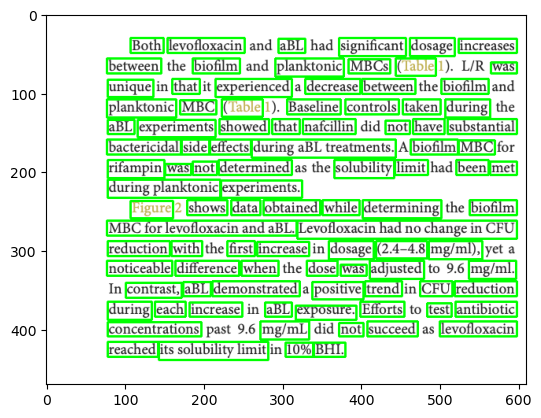

In [11]:
plot_components(comp_df_filtered,comps=comp_df_filtered.label_id.unique())

In [12]:
def plot_nn_patch(df,img,root_label, neighbor_labels):
            
    output = img.copy()
    count = 0
    x,y,w,h = df[df['label_id'] == root_label][['left','top','width','height']].values[0]  
    print(df[df['label_id'] == root_label])
    cv2.rectangle(output, (x, y), (x + w, y + h),(255,0,0) , 2)
    for neighbor in neighbor_labels:
        count += 1
        x1,y1,w1,h1 = df[df['label_id'] == neighbor][['left','top','width','height']].values[0]
        cv2.rectangle(output, (x1, y1), (x1 + w1, y1 + h1),(0, 255,0) , 2)
        cv2.putText(output, str(count), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)
        #cv2.circle(output, (100, 100), 5, (255, 255, 255), -1)
    plt.imshow(output)

In [13]:
def build_single_lexicon(label_id, df, k=5):
    if label_id not in df['label_id']:
        print("unknown component")
        return
    
    #extract word-coordinates
    x,y,w,h = df[df['label_id'] == label_id][['centroid_x','centroid_y','width','height']].values[0]

    #filter candidates
    c1 = (df['centroid_x'] >= x-w) & (df['centroid_x'] <= x+w)
    c2 = (df['centroid_y'] >= y-h) & (df['centroid_y'] <= y+h)
    temp_df = df[c1 & c2]
    window = 1
    while(temp_df.shape[0] <= k):
        window += 0.5
        c1 = (df['centroid_x'] >= x-(window*w)) & (df['centroid_x'] <= x+(window*w))
        c2 = (df['centroid_y'] >= y-(window*h)) & (df['centroid_y'] <= y+(window*h))
        temp_df = df[c1 & c2]
    
    #transalation-invariance 
    temp_df['new_centroid_x'] = (temp_df['centroid_x']-x)
    temp_df['new_centroid_y'] = (y-temp_df['centroid_y'])
    
    #rotation-invariance
    
    #scale-invariance
    temp_df['new_centroid_x'] = temp_df['new_centroid_x']/w
    temp_df['new_centroid_y'] = temp_df['new_centroid_y']/w
    
    #calculate distance & angle
    temp_df['Euclidean'] = np.sqrt(temp_df['new_centroid_y']**2 + temp_df['new_centroid_x']**2)
    temp_df['theta'] = np.degrees(np.arctan2(temp_df['new_centroid_y'], temp_df['new_centroid_x']))
    temp_df['theta'] = (temp_df['theta'] + 360) % 360 
    temp_df.loc[temp_df['theta'] > 350, 'theta'] = 0
    temp_df.loc[temp_df['theta'] < 2, 'theta'] = 0
    temp_df['quadrant'] = pd.cut(temp_df['theta'], 8, labels=range(1,9))
    
    temp_df['score'] = 0.5*(temp_df['theta']/360) +  0.5*(temp_df['Euclidean']/temp_df['Euclidean'].max())

    
    #get k-nn
    result_df = temp_df.sort_values(by=['quadrant','theta','Euclidean'])[1:]
    prev_value = result_df['theta'].shift(1)
    mask = abs(result_df['theta'] - prev_value) <= 5
    result_df = result_df[~mask].reset_index(drop=True)
    
    #return knn
    #nn = result_df[['new_centroid_x','new_centroid_x']].values
    #nn_labels = result_df['label_id'].values
    return temp_df#nn,nn_labels,result_df
    

In [14]:
word = 85
df = comp_df_filtered.copy()
candidate_df = build_single_lexicon(word, df,k=10)
candidate_df

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,new_centroid_x,new_centroid_y,Euclidean,theta,quadrant,score
56,57,329,82,70,19,664,363.685241,93.126506,3.68,-0.749009,0.376488,0.838306,153.313671,4,0.449148
57,58,401,82,68,19,674,432.735905,92.893175,3.58,0.266442,0.379920,0.464037,54.957555,2,0.207083
59,60,502,82,60,19,613,530.133768,91.601958,3.16,1.698764,0.398908,1.744972,13.214917,1,0.510041
83,84,306,108,68,19,675,339.696296,118.254815,3.58,-1.101787,0.006954,1.101809,179.638363,5,0.559958
84,85,380,108,68,19,628,414.617834,118.727707,3.58,0.000000,0.000000,0.000000,0.000000,1,0.000000
85,86,453,108,48,19,479,475.087683,118.440501,2.53,0.889262,0.004224,0.889273,0.000000,1,0.250573
86,87,507,108,57,23,589,535.281834,119.015280,2.48,1.774471,-0.004229,1.774476,0.000000,1,0.500000
103,104,287,133,35,19,400,303.445000,142.987500,1.84,-1.634895,-0.356762,1.673368,192.309935,5,0.738608
104,105,326,133,67,19,717,359.238494,142.748954,3.53,-0.814402,-0.353254,0.887716,203.449188,5,0.532703
106,107,466,133,40,19,418,484.468900,143.684211,2.11,1.027222,-0.367007,1.090816,340.339124,8,0.780056


In [15]:
cdf = candidate_df.sort_values(by=['quadrant','score','theta'])[1:]
cdf

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,new_centroid_x,new_centroid_y,Euclidean,theta,quadrant,score
85,86,453,108,48,19,479,475.087683,118.440501,2.53,0.889262,0.004224,0.889273,0.000000,1,0.250573
86,87,507,108,57,23,589,535.281834,119.015280,2.48,1.774471,-0.004229,1.774476,0.000000,1,0.500000
59,60,502,82,60,19,613,530.133768,91.601958,3.16,1.698764,0.398908,1.744972,13.214917,1,0.510041
57,58,401,82,68,19,674,432.735905,92.893175,3.58,0.266442,0.379920,0.464037,54.957555,2,0.207083
56,57,329,82,70,19,664,363.685241,93.126506,3.68,-0.749009,0.376488,0.838306,153.313671,4,0.449148
104,105,326,133,67,19,717,359.238494,142.748954,3.53,-0.814402,-0.353254,0.887716,203.449188,5,0.532703
83,84,306,108,68,19,675,339.696296,118.254815,3.58,-1.101787,0.006954,1.101809,179.638363,5,0.559958
103,104,287,133,35,19,400,303.445000,142.987500,1.84,-1.634895,-0.356762,1.673368,192.309935,5,0.738608
110,111,431,135,31,17,293,447.204778,143.822526,1.82,0.479220,-0.369041,0.604850,322.400559,8,0.618209
106,107,466,133,40,19,418,484.468900,143.684211,2.11,1.027222,-0.367007,1.090816,340.339124,8,0.780056


    label_id  left  top  width  height  area  centroid_x  centroid_y  \
84        85   380  108     68      19   628  414.617834  118.727707   

    aspect_ratio  
84          3.58  


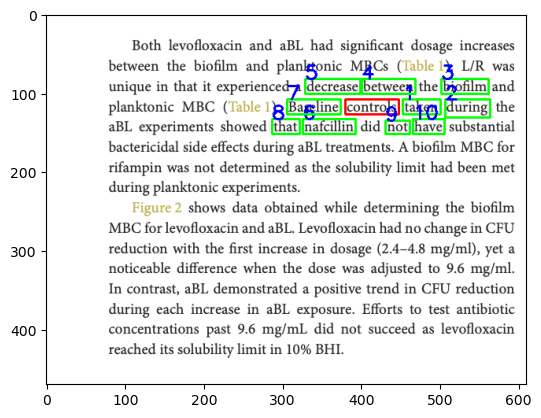

In [16]:
plot_nn_patch(df,img,word,cdf.label_id.unique())

In [17]:
cdf = candidate_df.sort_values(by=['quadrant','score','theta'])[1:]
df_filtered = cdf.groupby('quadrant').filter(lambda x: len(x) > 0)
df_filtered = df_filtered.groupby('quadrant').apply(lambda x: x.head(1)).reset_index(drop=True)
df_filtered

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio,new_centroid_x,new_centroid_y,Euclidean,theta,quadrant,score
0,86,453,108,48,19,479,475.087683,118.440501,2.53,0.889262,0.004224,0.889273,0.000000,1,0.250573
1,58,401,82,68,19,674,432.735905,92.893175,3.58,0.266442,0.379920,0.464037,54.957555,2,0.207083
2,57,329,82,70,19,664,363.685241,93.126506,3.68,-0.749009,0.376488,0.838306,153.313671,4,0.449148
3,105,326,133,67,19,717,359.238494,142.748954,3.53,-0.814402,-0.353254,0.887716,203.449188,5,0.532703
4,111,431,135,31,17,293,447.204778,143.822526,1.82,0.479220,-0.369041,0.604850,322.400559,8,0.618209


In [18]:
df_filtered.columns

Index(['label_id', 'left', 'top', 'width', 'height', 'area', 'centroid_x',
       'centroid_y', 'aspect_ratio', 'new_centroid_x', 'new_centroid_y',
       'Euclidean', 'theta', 'quadrant', 'score'],
      dtype='object')

    label_id  left  top  width  height  area  centroid_x  centroid_y  \
84        85   380  108     68      19   628  414.617834  118.727707   

    aspect_ratio  
84          3.58  


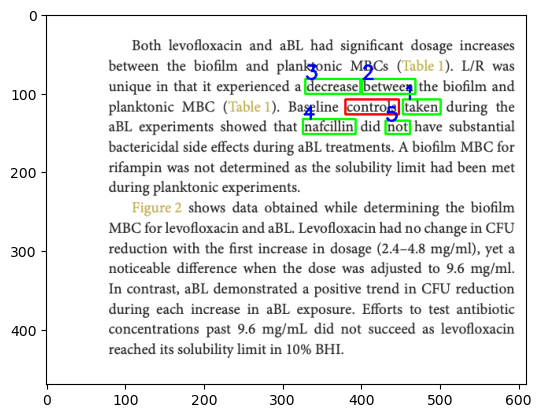

In [19]:
neighbors = df_filtered[df_filtered['label_id'] != word].label_id.unique()
plot_nn_patch(df,img,word,neighbors)

In [283]:
from scipy.spatial import Voronoi, voronoi_plot_2d

In [284]:
df.reset_index(drop=True,inplace=True)
df

,label_id,left,top,width,height,area,centroid_x,centroid_y,aspect_ratio
0,2,107,30,42,19,388,128.515464,39.796392,2.21
1,3,154,30,98,19,937,201.500534,40.469584,5.16
2,5,295,31,34,18,329,311.088146,40.024316,1.89
3,7,372,30,85,23,892,413.839686,40.659193,3.70
4,8,462,30,57,23,538,490.334572,41.392193,2.48
...,...,...,...,...,...,...,...,...,...
91,342,372,392,31,17,293,388.204778,400.822526,1.82
92,360,78,416,64,19,646,110.178019,426.411765,3.37
93,361,143,416,139,23,1527,212.889980,425.972495,6.04
94,363,304,417,35,18,377,320.816976,425.424403,1.94


In [285]:
df[['centroid_x','centroid_y']]

,centroid_x,centroid_y
0,128.515464,39.796392
1,201.500534,40.469584
2,311.088146,40.024316
3,413.839686,40.659193
4,490.334572,41.392193
...,...,...
91,388.204778,400.822526
92,110.178019,426.411765
93,212.889980,425.972495
94,320.816976,425.424403


In [309]:
points = [[x, y] for x, y in zip(df['centroid_x'], df['centroid_y'])]
points

[[128.51546391752578, 39.79639175257732],
 [201.50053361792956, 40.46958377801494],
 [311.08814589665656, 40.02431610942249],
 [413.8396860986547, 40.65919282511211],
 [490.3345724907063, 41.39219330855018],
 [559.7022471910112, 41.122191011235955],
 [108.82518518518519, 67.01037037037037],
 [214.20922570016475, 65.52883031301482],
 [332.9430167597765, 66.5195530726257],
 [410.12714776632305, 65.50171821305842],
 [467.2125850340136, 65.61904761904762],
 [581.129746835443, 67.44620253164557],
 [107.0034965034965, 93.47727272727273],
 [176.52592592592592, 91.98765432098766],
 [262.9197465681098, 93.14572333685322],
 [363.68524096385545, 93.12650602409639],
 [432.7359050445104, 92.89317507418397],
 [530.1337683523655, 91.60195758564437],
 [119.21290322580646, 118.56451612903226],
 [192.90729783037474, 117.20118343195266],
 [247.12599681020734, 117.75757575757575],
 [339.6962962962963, 118.25481481481482],
 [414.61783439490443, 118.72770700636943],
 [475.0876826722338, 118.44050104384134],

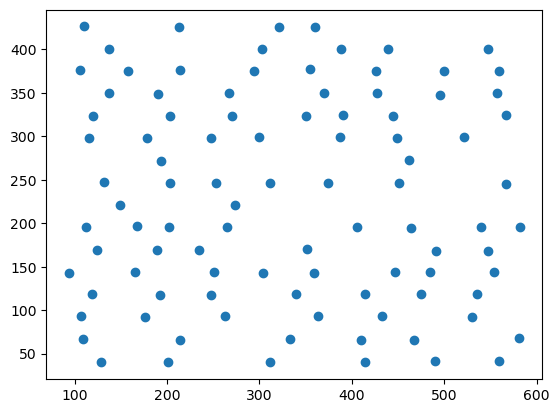

In [287]:
plt.scatter([point[0] for point in points],[point[1] for point in points])

In [288]:
vor = Voronoi(points)

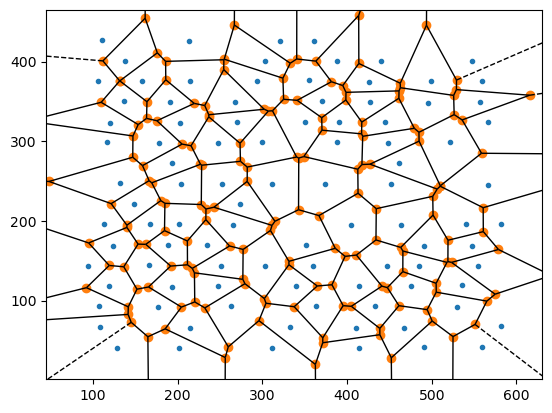

In [289]:
fig = voronoi_plot_2d(vor)
plt.show()

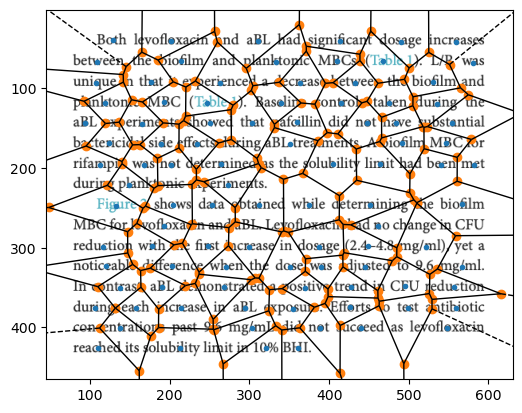

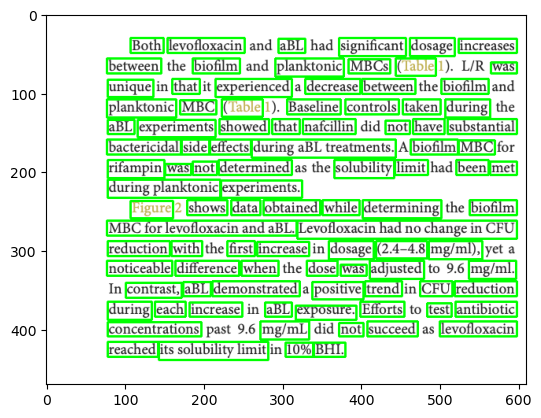

In [292]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
fig =  voronoi_plot_2d(vor, ax=plt.gca())
plt.gca().invert_yaxis()
plt.show()
plot_components(comp_df_filtered,comps=comp_df_filtered.label_id.unique())

In [303]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [310]:
hull = ConvexHull(points)

TypeError: list indices must be integers or slices, not tuple

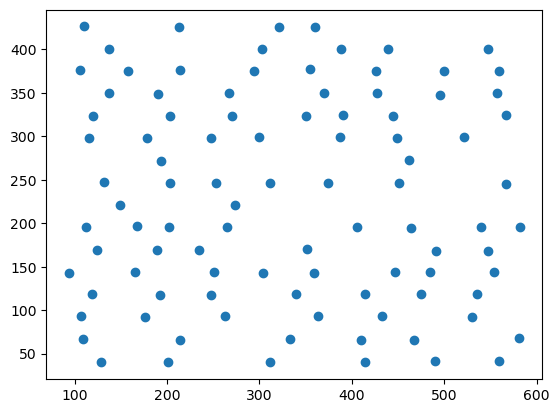

In [316]:
plt.plot([point[0] for point in points], [point[1] for point in points], 'o')
for simplex in hull.simplices:
    plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

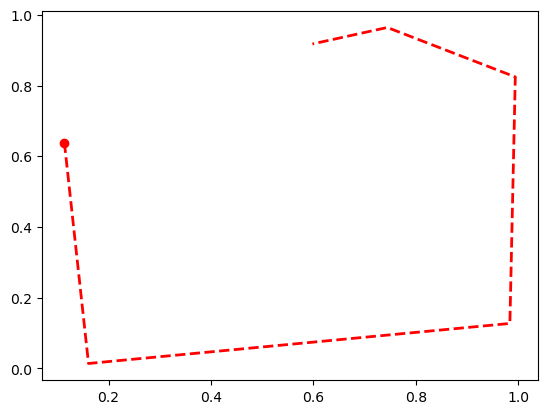

In [306]:
plt.plot(points[hull.vertices,0], points[hull.vertices,1], 'r--', lw=2)
plt.plot(points[hull.vertices[0],0], points[hull.vertices[0],1], 'ro')
plt.show()